Paquetes necesarios

In [158]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

TAREA: Captura una o varias imágenes con coinCount no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de coinCount y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

In [159]:
def locateCirclesInIMG(img):
    return cv2.HoughCircles(
    img,  # imagen 
    cv2.HOUGH_GRADIENT,  # tipo de detección
    1,
    100,  # distancia mínima entre círculos
    param1=90, # valor del gradiente
    param2=40, # umbral acumulador
    minRadius=50,  # radio mínimo
    maxRadius=150,  # radio máximo
    )[0]


def coinDiameterInPixels(coin):
    return coin[2]*2


def pixelMeasurementInCM(coinDiameterInPixels, coinDiameterInCM):
    return coinDiameterInCM/coinDiameterInPixels


def moneyCalculator(coins):
    money = 0
    for coin, num in coins.items():
            money += coin*num
    return round(money, 2)


def isInCircle(point, center, radius):
    x, y = point
    xCenter, yCenter = center
    
    # Calcular la distancia al cuadrado
    squareDistance = (x - xCenter) ** 2 + (y - yCenter) ** 2
    
    # Comparar con el radio al cuadrado
    return squareDistance <= radius ** 2


def showResults(moneyAmount, realMoneyAmount, coinCount, realCoinCount):
    print("\n=== Resultados de Detección de Monedas ===")
    
    # Mostrar el total de dinero encontrado
    print(f"Dinero total real (esperado): {realMoneyAmount:.2f} €")

    # Mostrar el total de dinero encontrado
    print(f"Dinero total encontrado: {moneyAmount:.2f} €\n")
    
    # Mostrar las monedas reales (esperadas)
    print("Monedas reales (esperadas):")
    for coin, count in realCoinCount.items():
        print(f"Moneda de {coin:.2f} €: {count} unidades")

    print("\nMonedas encontradas (detectadas):")
    for coin, count in coinCount.items():
        print(f"Moneda de {coin:.2f} €: {count} unidades")
    
    # Mostrar diferencias
    print("\nDiferencias entre monedas reales y encontradas:")
    for coin in realCoinCount.keys():
        real_count = realCoinCount[coin]
        found_count = coinCount[coin]
        diff = found_count - real_count
        if diff != 0:
            print(f"Moneda de {coin:.2f} €: diferencia de {diff} unidades")
        else:
            print(f"Moneda de {coin:.2f} €: sin diferencia")
    
    print("\n==========================================\n")


In [160]:
img = cv2.imread('monedas2.jpeg')                                                   # Carga imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                      # Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                        # Conversión a gris
softenedImage = cv2.medianBlur(gris, 7)                                             # Suaviza imagen (elimina altas frecuencias)
softenedImage2 = cv2.GaussianBlur(softenedImage, (5, 5), 1)                         # Suavizar la imagen con filtro gaussiano
 
realMoneyAmount = 2.34
realCoinCount = {2.0: 0, 1.0: 2, 0.50: 0, 0.20: 1, 0.10: 1, 0.05: 0, 0.02: 1, 0.01: 2}
coinSizes = {2: 25.75, 1: 23.25, 0.5: 24.35, 0.2: 22.25, 0.1: 19.75, 0.05: 21.25, 0.02: 18.75, 0.01: 16.26}

circles = locateCirclesInIMG(softenedImage2)


# A partir de unas coordenadas x,y devuelve que circulo contiene esas coordenadas
def locate1EURCoin(x, y):
    for i in range(len(circles)):
        if (isInCircle((x,y), ((circles[i][0]),circles[i][1]),circles[i][2])):
            return circles[i]


# Definir el callback para manejar los eventos del mouse
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Verifica si se hizo clic con el botón izquierdo
        moneyAmount = 0 
        coinCount = {2.0: 0, 1.0: 0, 0.50: 0, 0.20: 0, 0.10: 0, 0.05: 0, 0.02: 0, 0.01: 0}

        pixelInCM = pixelMeasurementInCM(coinDiameterInPixels(locate1EURCoin(x, y)), 23.25)

        # Para cada circulo encontrado se asigna la moneda correspondiente a su tamaño   
        for circle in circles:
            coinType=0
            diff=10
            coinDiameterInCM = coinDiameterInPixels(circle) * pixelInCM

            for coin, size in coinSizes.items():
                if (abs(size-coinDiameterInCM) <= diff ):
                    diff = abs(size-coinDiameterInCM)
                    coinType = coin
            
            coinCount[coinType] += 1
        
        moneyAmount = moneyCalculator(coinCount)
        showResults(moneyAmount, realMoneyAmount, coinCount, realCoinCount)
                                     

# Dibuja los circulos encontrados en la imagen
for det in circles:
    x_coor, y_coor, det_radio = det
    cv2.circle(img,(int(x_coor), int(y_coor)),
        int(det_radio),(0, 255, 0), 2)


cv2.imshow('Monedas', img)
cv2.setMouseCallback('Monedas', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()


TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [161]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

# Función para calcular la distancia euclidiana entre los centros de dos rectángulos
def distancia_centros(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    centro1 = (x1 + w1 // 2, y1 + h1 // 2)
    centro2 = (x2 + w2 // 2, y2 + h2 // 2)
    return np.sqrt((centro1[0] - centro2[0]) ** 2 + (centro1[1] - centro2[1]) ** 2)

def isBlack(punto):
    # Definir el rango de colores en HSV
    lower_bound = np.array([0, 0, 0])
    upper_bound = np.array([180, 255, 170])

    # Comprobar si el valor del píxel está dentro del rango
    if cv2.inRange(np.array([[punto]]), lower_bound, upper_bound):
        return True
    else:
        return False

In [162]:
def pruebaSeparado(url):
    imagen = cv2.imread(url)

    imagen_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    imagen_suavizada = cv2.GaussianBlur(imagen_gray, (7, 7), 0)

    # Aplicar umbral adaptativo gaussiano
    imagen_umbral = cv2.adaptiveThreshold(
        imagen_suavizada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 1
    )

    """imagen_umbral_mostrar = ResizeWithAspectRatio(imagen_umbral, height=1080)

    cv2.imshow('Fragmentos detectados', imagen_umbral_mostrar)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""

    # Aplicar operaciones morfológicas para eliminar ruido
    kernel = np.ones((3, 3), np.uint8)
    imagen_umbral = cv2.morphologyEx(imagen_umbral, cv2.MORPH_OPEN, kernel)

    # Encontrar los contornos de los fragmentos
    contornos_gaussian, _ = cv2.findContours(255-imagen_umbral, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar los contornos según el área
    contornos_filtrados = [contorno for contorno in contornos_gaussian if cv2.contourArea(contorno) > 150]

    # Eliminar contornos cercanos basándose en la distancia mínima
    distancia_minima = 25
    contornos_finales = []

    rectangulos = [cv2.boundingRect(c) for c in contornos_filtrados]

    # Comparar cada rectángulo con los otros y eliminar los cercanos
    for i, rect1 in enumerate(rectangulos):
        es_cercano = False
        for j, rect2 in enumerate(rectangulos):
            if i != j and distancia_centros(rect1, rect2) < distancia_minima:
                es_cercano = True
                break
        if not es_cercano:
            contornos_finales.append(contornos_filtrados[i])

    # Dibujar los contornos detectados en la imagen original
    imagen_contornos = imagen.copy()
    cv2.drawContours(imagen_contornos, contornos_finales, -1, (0, 255, 0), 3)

 
    num_fragmentos = len(contornos_finales)

    cv2.putText(imagen_contornos, f'Fragmentos: {num_fragmentos}', (10,125), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 8)
    #print(f"Número de fragmentos detectados: {num_fragmentos}")


    imagen_contornos = ResizeWithAspectRatio(imagen_contornos, height=1080)


    cv2.imshow('Fragmentos detectados', imagen_contornos)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [163]:
def pruebaJuntos():
    imagen = cv2.imread('MPs.jpg')

    imagen_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    imagen_suavizada = cv2.GaussianBlur(imagen_gray, (3, 3), 0)

    # Aplicar umbral adaptativo gaussiano
    imagen_umbral = cv2.adaptiveThreshold(
        imagen_suavizada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 1.5  
    )

    """imagen_umbral_mostrar = ResizeWithAspectRatio(imagen_umbral, height=1080)

    cv2.imshow('Fragmentos detectados', 255-imagen_umbral_mostrar)
    cv2.waitKey(0)
    cv2.destroyAllWindows()"""

    # Aplicar operaciones morfológicas para eliminar ruido
    kernel = np.ones((5, 5), np.uint8)
    imagen_umbral = cv2.morphologyEx(imagen_umbral, cv2.MORPH_OPEN, kernel)

    # Encontrar los contornos de los fragmentos
    contornos_gaussian, _ = cv2.findContours(255-imagen_umbral, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar los contornos según el área
    contornos_filtrados = [contorno for contorno in contornos_gaussian if cv2.contourArea(contorno) > 100]

    # Eliminar contornos cercanos basándose en la distancia mínima
    distancia_minima = 25
    contornos_finales = []

    rectangulos = [cv2.boundingRect(c) for c in contornos_filtrados]

    # Comparar cada rectángulo con los otros y eliminar los cercanos
    for i, rect1 in enumerate(rectangulos):
        es_cercano = False
        for j, rect2 in enumerate(rectangulos):
            if i != j and distancia_centros(rect1, rect2) < distancia_minima:
                es_cercano = True
                break
        if not es_cercano:
            contornos_finales.append(contornos_filtrados[i])


    
    Particulas = {'Pellet': 0, 'Fragmento de microplástico': 0, 'Alquitrán': 0, 'Otras': 0}
    
    prediction = []
    reales = [2,1,2,2,1,1,1,2,1,0,1,2,0,2,1,1,2,2,2,0,2,1,0,2,2,1,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,1,2,1,2,2,2,2,2,2,2,0,1,2,2,2,1,2,1,0,2,2,2,2,1,0,0,2,1,1,2,0,2,0,2,2,
              0,0,2,1,2,0,1,1,1,2,1,2,2,2,2,2,1,2,2,2]
    
    pellet = []
    plastic = []
    alqui = []


    def clasificar_fragmento(area, circularidad, contorno, colorPixel):
        if isBlack(colorPixel):  # Fragmentos de color oscuro (suponemos alquitran)
            Particulas['Alquitrán'] +=1
            alqui.append(contorno)
            prediction.append(0)

        elif circularidad > 0.70 and area > 75:  # Fragmentos redondos
            Particulas['Pellet'] +=1
            pellet.append(contorno)
            prediction.append(1)
        else:
            Particulas['Fragmento de microplástico'] +=1
            plastic.append(contorno)
            prediction.append(2)


    """
    #comprobar elemento a elemento
    
    imagenPrueba = imagen.copy()
    contornoAnterior = contornos_finales[0]
    for contorno in contornos_finales:
        cv2.drawContours(imagenPrueba, contorno, -1, (255, 0, 0), 2)
        cv2.drawContours(imagenPrueba, contornoAnterior, -1, (0, 255, 0), 2)
        contornoAnterior = contorno

        # Mostrar la imagen con los contornos dibujados y el texto
        cv2.imshow('Fragmentos detectados', imagenPrueba)
        cv2.waitKey(0)
        cv2.destroyAllWindows()"""

    imagenHSV = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    #clasificar elementos
    for contorno in contornos_finales:
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        (x, y, w, h) = cv2.boundingRect(contorno)
        centroX, centroY = (x + w // 2, y + h // 2)
        circularidad = (4 * np.pi * area) / (perimetro ** 2)

        clasificar_fragmento(area, circularidad,contorno, imagenHSV[centroY, centroX])




    # Dibujar los contornos detectados en la imagen original
    imagen_contornos = imagen.copy()
    cv2.drawContours(imagen_contornos, pellet, -1, (255, 0, 0), 2)
    cv2.drawContours(imagen_contornos, plastic, -1, (0, 255, 0), 2)
    cv2.drawContours(imagen_contornos, alqui, -1, (0, 0, 255), 2)

    num_fragmentos = len(contornos_finales)

    cv2.putText(imagen_contornos, f'Fragmentos: {num_fragmentos}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    #print(f"Número de fragmentos detectados: {num_fragmentos}")

    imagen_contornos = ResizeWithAspectRatio(imagen_contornos, height=1080)

    cv2.imshow('Fragmentos detectados', imagen_contornos)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return (reales, prediction)

In [164]:
def results(real, prediction):
    #Cálculo de métricas
    accuracy = accuracy_score(real, prediction)
    #Para más de una clase se define la forma de promediar
    precision = precision_score(real, prediction,average='weighted')
    recall = recall_score(real, prediction,average='weighted')
    f1score = f1_score(real, prediction,average='weighted')

    print(f"Accuracy (TP/(n))= {accuracy}")
    print(f"Precision (TP/(TP+FP)) = {precision}")
    print(f"Recall (TP/(TP+FN)) = {recall}")
    print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


    conf_matrix = confusion_matrix(real, prediction)
    plt.figure(figsize=(8,8))
    sns.set(font_scale = 1.75)#tamaños tipografía
    sns.set(font_scale = 3.0)

    ax = sns.heatmap(
            conf_matrix, # confusion matrix 2D array 
            annot=True, # Muestra números en las celdas
            fmt='d', # valores enteros
            cbar=False, # sin barra de colores
            cmap='flag', # mapa de colores
            #vmax=175 # contraste de color
        )

    #Etiquetas matriz de confusión
    label_font = {'size':'25'}
    ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
    ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)


Accuracy (TP/(n))= 0.819047619047619
Precision (TP/(TP+FP)) = 0.8386795830546717
Recall (TP/(TP+FN)) = 0.819047619047619
F1 Score (2*(precision*recall)/(precision+recall)) = 0.8225576349702521


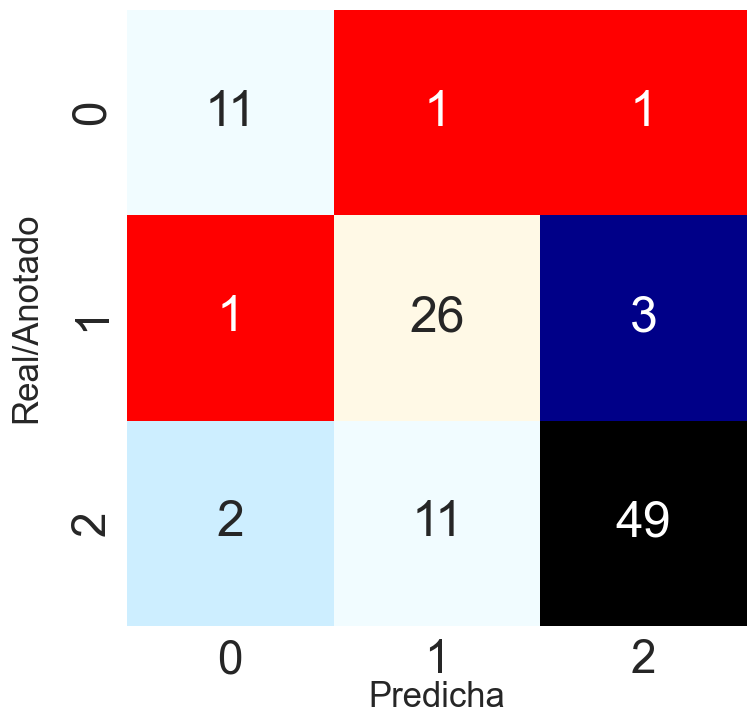

In [165]:
imgF = 'fragment-03-olympus-10-01-2020.JPG'
imgP = 'pellet-03-olympus-10-01-2020.JPG'
imgT = 'tar-03-olympus-10-01-2020.JPG'

pruebaSeparado(imgF)
pruebaSeparado(imgP)
pruebaSeparado(imgT)
real, predict = pruebaJuntos()
results(real, predict)
